### Ideas 

1. Missing values in test: use median of `item_cat1` and `item_cat2` to replace `NaN`
2. Moving average of different months
3. Difference between Moving averages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import sys
import time
import gc
import itertools
import tqdm
import time
import copy

from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss

if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass
    
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from numba import jit

%matplotlib inline

## Helper Functions

In [2]:
def clip_rmse(preds, dtrain):
    y_test = np.array(dtrain.get_label())
    preds = np.array(preds)
    y_test = np.maximum(np.minimum(y_test, 20), 0)
    preds = np.maximum(np.minimum(preds, 20), 0)
    #preds = np.array(list(map(lambda x: min(20, max(x, 0)), list(preds))))
    #y_test = np.array(list(map(lambda x: min(20, max(x, 0)), list(y_test))))
    rmse = np.sqrt(mean_squared_error(preds,y_test))
    return 'clip-rmse', rmse

In [3]:
def cv_predict(param, n_tree, x_train, y_train, month_in_cv, sub_name, verbose=False):
    '''CV and predict'''
    progress = dict()
    bst_cv = dict()
    
    for m in month_in_cv:
        if m<month_in_cv[-2]:
            # CV 
            print('CV of month {} is started.'.format(m))
            time_start = time.time()
            progress[m] = {}
            dtrain = xgb.DMatrix(x_train[m], y_train[m], nthread=-1)
            dval = xgb.DMatrix(x_train[m+1], y_train[m+1], nthread=-1)
            watchlist = [(dtrain, 'train'), (dval, 'val')]

            bst_cv[m] = xgb.train(param, 
                            dtrain, 
                            evals=watchlist,
                            evals_result=progress[m], 
                            verbose_eval=verbose,
                            num_boost_round=n_tree,
                            feval=clip_rmse)

            time_end = time.time()

            print('CV of month {} is finished, uses {:.2f} sec, clip-rmse on val {:.2f}\n'.format(m, 
                time_end-time_start, progress[m]['val']['clip-rmse'][-1]))
            
        elif m==month_in_cv[-2]:
            # Train the last cv model for prediction
            print('Training of month {} is started.'.format(m))
            time_start = time.time()
            dtrain = xgb.DMatrix(x_train[m], y_train[m], nthread=-1)
            watchlist = [(dtrain, 'train')]

            bst_cv[m] = xgb.train(param, 
                            dtrain, 
                            evals=watchlist,
                            verbose_eval=verbose,
                            num_boost_round=n_tree,
                            feval=clip_rmse)

            time_end = time.time()
            print('Train of month {} is finished, uses {:.2f} sec.\n'.format(m, time_end-time_start))
                  
        else:
            # Prediction
            print('Predicting of month {} is started.'.format(m))
            preds = bst_cv[m-1].predict(xgb.DMatrix(x_train[m]))
            preds = list(map(lambda x: min(20, max(x, 0)), list(preds)))
            sub_df = pd.DataFrame({'ID': cnt.index, 'item_cnt_month': preds})
            sub_df.to_csv(sub_name, index=False)
            print('Prediction of month {} is finished.\n'.format(m))
        
    progress = {m: {'train': progress[m]['train']['clip-rmse'], 
            'val': progress[m]['val']['clip-rmse']} 
        for m in progress.keys()}
    progress = pd.DataFrame({(m, k): progress[m][k] 
                             for m in progress.keys() 
                             for k in progress[m].keys()})
    
    return progress, bst_cv, sub_df

In [4]:
def ensemble(n_model, param, n_tree, x_train, y_train, month_in_cv, sub_name, verbose=True, random_state=42):
    '''Change random seed and train, then combine predictions'''
    
    np.random.seed(random_state)
    
    bst = {}
    preds = []
    m = month_in_cv[-2]
    
    for n in range(n_model):
        # Train the model with a different random seed
        param['seed'] = np.random.randint(100000)
        
        # Train the last cv model for prediction
        print('Start training model {} on month {}'.format(n, m))
        time_start = time.time()
        dtrain = xgb.DMatrix(x_train[m], y_train[m], nthread=-1)
        watchlist = [(dtrain, 'train')]

        bst[n] = xgb.train(param, 
                        dtrain, 
                        evals=watchlist,
                        verbose_eval=verbose,
                        num_boost_round=n_tree,
                        feval=clip_rmse)

        time_end = time.time()
        print('Train of model {} on month {} is finished, uses {:.2f} sec.\n'.format(n, m, time_end-time_start))

        # Prediction
        print('Start predicting model {} on month {}.'.format(n, m+1))
        preds.append(bst[n].predict(xgb.DMatrix(x_train[m+1])))
        print('Prediction of model {} on month {} is finished.\n'.format(n, m+1))
        
        print('---------------------------------------\n')
    
    preds_mean = np.array(preds).mean(axis=0)
    preds_mean = list(map(lambda x: min(20, max(x, 0)), list(preds_mean)))
    preds_mean = pd.DataFrame({'ID': cnt.index, 'item_cnt_month': preds_mean})
    preds_mean.to_csv(sub_name, index=False)
    
    
    return bst, preds, preds_mean

In [5]:
def cv_predict_repeat(param, n_tree, n_repetition, x_train, y_train, month_in_cv, sub_name, random_state=42, verbose=False):
    '''CV and predict'''
    progress = dict()
    bst_cv = dict()
    preds = []
    
    np.random.seed(random_state)
    
    for n in range(n_repetition):
        param['seed'] = np.random.randint(1000000)
        print('Repetition {} starts.'.format(n))
        for m in month_in_cv:
            if m<month_in_cv[-2]:
                # CV 
                print('CV of month {} is started.'.format(m))
                time_start = time.time()
                progress[n, m] = {}
                dtrain = xgb.DMatrix(x_train[m], y_train[m], nthread=-1)
                dval = xgb.DMatrix(x_train[m+1], y_train[m+1], nthread=-1)
                watchlist = [(dtrain, 'train'), (dval, 'val')]

                bst_cv[n, m] = xgb.train(param, 
                                dtrain, 
                                evals=watchlist,
                                evals_result=progress[n, m], 
                                verbose_eval=verbose,
                                num_boost_round=n_tree,
                                feval=clip_rmse)

                time_end = time.time()

                print('CV of month {} is finished, uses {:.2f} sec, clip-rmse on val {:.4f}\n'.format(m, 
                    time_end-time_start, progress[n, m]['val']['clip-rmse'][-1]))

            elif m==month_in_cv[-2]:
                # Train the last cv model for prediction
                print('Training of month {} is started.'.format(m))
                time_start = time.time()
                dtrain = xgb.DMatrix(x_train[m], y_train[m], nthread=-1)
                watchlist = [(dtrain, 'train')]

                bst_cv[n, m] = xgb.train(param, 
                                dtrain, 
                                evals=watchlist,
                                verbose_eval=verbose,
                                num_boost_round=n_tree,
                                feval=clip_rmse)

                time_end = time.time()
                print('Train of month {} is finished, uses {:.2f} sec.\n'.format(m, time_end-time_start))

            else:
                # Prediction
                print('Predicting of month {} is started.'.format(m))
                
                preds_current = bst_cv[n, m-1].predict(xgb.DMatrix(x_train[m]))
                preds.append(preds_current)
                print('Prediction of month {} is finished.\n'.format(m))
        print('Repetition {} finishes.'.format(n))
        print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\n\n\n')
    
    # Prediction for testing data set
    preds_mean = np.array(preds).mean(axis=0)
    preds_mean = list(map(lambda x: min(20, max(x, 0)), list(preds_mean)))
    preds_mean = pd.DataFrame({'ID': cnt.index, 'item_cnt_month': preds_mean})
    preds_mean.to_csv(sub_name, index=False)
    
    # CV results
    progress = {(n, m): {'train': progress[n, m]['train']['clip-rmse'], 
            'val': progress[n, m]['val']['clip-rmse']} 
        for (n, m) in progress.keys()}
    progress = pd.DataFrame({(m, k): progress[m][k] 
                             for m in progress.keys() 
                             for k in progress[m].keys()})
    
    # Process the DataFrame
    index_level = [k.tolist() for k in progress.columns.levels]
    index_level = list(itertools.product(index_level[0], index_level[1]))
    index_level_1, index_level_2 = zip(*index_level)
    index_level_tuples = []
    for i in range(len(index_level_1)):
        tmp = list(index_level_1[i])
        tmp.append(index_level_2[i])
        index_level_tuples.append(tuple(tmp))
    progress.columns = pd.MultiIndex.from_tuples(index_level_tuples, names=['repetition', 'month', 'data'])
    progress.index.name = 'iteration'
    
    # Average over multiple repetitions
    # progress_mean_repetition = progress.groupby(level=[1, 2], axis=1).mean()
    # Average and standard deviation over multiple repetitions and months
    #progress_mean_std = progress.groupby(level=2, axis=1).agg(np.mean, np.std)
    
    return progress, bst_cv, preds_mean

In [6]:
def create_train_data(feature_fixed_list, feature_rolling_dict, month_in_model=31, month_test=34, 
                      month_in_cv=None, features=None):
    '''
    Return x_train and y_train
    month_in_cv can be None or 33, 33 is for feature importance calculation
    month_test is the month to be tested
    month_in_model+len(month_in_cv)-1<=month_test
    '''
    if month_in_cv is None:
        month_in_cv = list(range(month_in_model, month_test+1))
    
    assert (month_in_model+len(month_in_cv)-1<=month_test), 'Months are not correct!'
    
    cols_cv = {k: list(range(k-month_in_model, k)) for k in month_in_cv} # The last month is test
    x_train = {}
    y_train = {}
    for m in month_in_cv:
        print(m)
        df_list = copy.copy(feature_fixed_list)
        df_list.extend([feature_rolling_dict[k].iloc[:, cols_cv[m]] 
                        for k in feature_rolling_dict.keys()])
        if features is None:
            x_train[m] = pd.concat(df_list, axis=1, sort=False).values
        else:
            x_train[m] = pd.concat(df_list, axis=1, sort=False).values[:, features]
        if m<month_test:
             # only train months have y_train, test month does not have it
             # clip ground truth since the objective is clipped
            y_train[m] = np.maximum(np.minimum(cnt.iloc[:, m].values, 40.0), 0.0)
            
    feature_names = pd.concat(df_list, axis=1, sort=False).columns # feature names of the last month
            
    return x_train, y_train, feature_names, month_in_model, month_test, month_in_cv, df_list
        

## Feature Engineering

#### Load and Prepare Data

In [7]:
# Load data
train = pd.read_csv('all/sales_train.csv.gz')
test = pd.read_csv('all/test.csv.gz')
shop = pd.read_csv('all/shops-translated.csv')
item = pd.read_csv('all/item_category.csv')

test.set_index('ID', inplace=True)
item.drop(['item_name_translated'], axis=1, inplace=True)
shop.drop(['Name'], axis=1, inplace=True)

le = LabelEncoder()
item['item_cat1'] = le.fit_transform(item['item_cat1'].astype(str))
item['item_cat2'] = le.fit_transform(item['item_cat2'].astype(str))
shop['City'] = le.fit_transform(shop['City'])
shop['Type'] = le.fit_transform(shop['Type'])

# test = test.merge(item, on='item_id', how='left')
# test = test.merge(shop, on='shop_id', how='left')

#### Counts of sales

In [8]:
# count of sales per month
cnt = train.pivot_table(index=['shop_id', 'item_id'],
                        columns=['date_block_num'],
                        values='item_cnt_day',
                        aggfunc='sum').fillna(0.0)

cnt = test.join(cnt, on=['shop_id', 'item_id'], how='left').fillna(0.0)
cnt.drop(['shop_id', 'item_id'], axis=1, inplace=True)
cnt.columns = ['cnt_'+str(k) for k in cnt.columns]

#### Value of sales

In [9]:
# total value of sales per month
train['sales'] = train['item_cnt_day']*train['item_price']
sales = train.pivot_table(index=['shop_id', 'item_id'],
                         columns='date_block_num',
                         values='sales',
                         aggfunc=np.sum).fillna(0.0)

sales = test.join(sales, on=['shop_id', 'item_id'], how='left').fillna(0.0)
sales.drop(['shop_id', 'item_id'], axis=1, inplace=True)
sales.columns = ['sales_'+str(k) for k in sales.columns]

#### Shops and Items

In [10]:
test_shop_item = test.merge(shop, on=['shop_id'], how='left')
test_shop_item = test_shop_item.merge(item, on=['item_id'], how='left')

### Mean Encoding

In [14]:
# Apply pivot table with combinations of the following parameters
index_list = ['item_id', 'shop_id', 'City', 'Type', 'item_cat1', 'item_cat2']
column_list = ['date_block_num']
value_list = ['item_price', 'item_cnt_day', 'sales'] # ['item_price', 'item_cnt_day', 'sales']

quantile_low = lambda x: np.quantile(x, 0.25)
quantile_high = lambda x: np.quantile(x, 0.75)
quantile_low_2 = lambda x: np.quantile(x, 0.1)
quantile_high_2 = lambda x: np.quantile(x, 0.9)
aggfunc_list = [('sum', np.sum), ('mean', np.mean), ('std', np.std), 
                ('median', np.median), ('ql', quantile_low), ('qh', quantile_high), 
                ('ql2', quantile_low_2), ('qh2', quantile_high_2)]
#aggfunc_list = [('sum', np.sum), ('mean', np.mean), ('std', np.std), ('median', np.median)]
#aggfunc_list = [('median', np.median)]

x = train.merge(shop, on='shop_id', how='left')
x = x.merge(item, on='item_id', how='left')

In [15]:
cols_drop = ['shop_id', 'item_id', 'City', 'Type', 'item_cat1', 'item_cat2']

In [16]:
feature_rolling_dict = {}
feature_rolling_dict['cnt'] = cnt
feature_rolling_dict['sales'] = sales
for idx, col, val, agf in tqdm.tqdm_notebook(list(itertools.product(index_list, column_list, value_list, aggfunc_list))):
    tmp = x.pivot_table(index=idx, columns=col, values=val, aggfunc=agf[1]).fillna(0.0)
    tmp_name = '-'.join([idx, val, agf[0]])
    tmp.columns = [tmp_name+'_'+str(k) for k in tmp.columns]
    tmp = test_shop_item.merge(tmp, on=idx, how='left').fillna(0.0)
    tmp.drop(cols_drop, axis=1, inplace=True)
    feature_rolling_dict[tmp_name] = tmp

In [17]:
feature_rolling_dict.keys()

dict_keys(['cnt', 'sales', 'item_id-item_price-sum', 'item_id-item_price-mean', 'item_id-item_price-std', 'item_id-item_price-median', 'item_id-item_price-ql', 'item_id-item_price-qh', 'item_id-item_price-ql2', 'item_id-item_price-qh2', 'item_id-item_cnt_day-sum', 'item_id-item_cnt_day-mean', 'item_id-item_cnt_day-std', 'item_id-item_cnt_day-median', 'item_id-item_cnt_day-ql', 'item_id-item_cnt_day-qh', 'item_id-item_cnt_day-ql2', 'item_id-item_cnt_day-qh2', 'item_id-sales-sum', 'item_id-sales-mean', 'item_id-sales-std', 'item_id-sales-median', 'item_id-sales-ql', 'item_id-sales-qh', 'item_id-sales-ql2', 'item_id-sales-qh2', 'shop_id-item_price-sum', 'shop_id-item_price-mean', 'shop_id-item_price-std', 'shop_id-item_price-median', 'shop_id-item_price-ql', 'shop_id-item_price-qh', 'shop_id-item_price-ql2', 'shop_id-item_price-qh2', 'shop_id-item_cnt_day-sum', 'shop_id-item_cnt_day-mean', 'shop_id-item_cnt_day-std', 'shop_id-item_cnt_day-median', 'shop_id-item_cnt_day-ql', 'shop_id-item_

### Find Important Features

Train 1 random models on data and find the most important 100 features

In [19]:
feature_fixed_list = [test_shop_item]
x_train, y_train, feature_names, month_in_model, month_test, month_in_cv, df_list = create_train_data(feature_fixed_list, feature_rolling_dict, 
                                     month_in_model=31, month_test=34, month_in_cv=[33])

33


month_in_model = 31
month_test = 34
month_in_cv = list(range(month_in_model, 35))
cols_cv = {k: list(range(k-month_in_model, k)) for k in month_in_cv} # The last month is test
month_in_cv = [33]

x_train = {}
y_train = {}
for m in month_in_cv:
    print(m)
    df_list = [test_shop_item, 
            cnt.iloc[:, cols_cv[m]], 
            sales.iloc[:, cols_cv[m]]]
    df_list.extend([feature_rolling[k].iloc[:, cols_cv[m]] 
                    for k in feature_rolling.keys()])
    x_train[m] = pd.concat(df_list, axis=1, sort=False).values
    if m<month_test:
         # only train months have y_train, test month does not have it
         # clip ground truth since the objective is clipped
        y_train[m] = np.maximum(np.minimum(cnt.iloc[:, m].values, 40.0), 0.0)

In [26]:
param = {'max_depth':14, 
         'subsample':0.9,
         'min_child_weight':3,
         'eta':0.03, 
         'lambda':2,
         'colsample_bytree':0.6,
         'seed':1,
         'silent':1,
         'eval_metric':'rmse',
         'maximize': False,
         'nthread':8}
n_tree = 40

dtrain = xgb.DMatrix(x_train[33], y_train[33], nthread=-1)
bst = xgb.train(param, dtrain, evals=[(dtrain, 'train')], verbose_eval=True, num_boost_round=n_tree, feval=clip_rmse)

[0]	train-rmse:1.31671	train-clip-rmse:1.09207
[1]	train-rmse:1.29682	train-clip-rmse:1.07312
[2]	train-rmse:1.27822	train-clip-rmse:1.05548
[3]	train-rmse:1.25339	train-clip-rmse:1.03236
[4]	train-rmse:1.22939	train-clip-rmse:1.01008
[5]	train-rmse:1.21173	train-clip-rmse:0.993482
[6]	train-rmse:1.18965	train-clip-rmse:0.973128
[7]	train-rmse:1.16775	train-clip-rmse:0.953196
[8]	train-rmse:1.1518	train-clip-rmse:0.938511
[9]	train-rmse:1.13042	train-clip-rmse:0.919192
[10]	train-rmse:1.11561	train-clip-rmse:0.905735
[11]	train-rmse:1.10133	train-clip-rmse:0.892899
[12]	train-rmse:1.08243	train-clip-rmse:0.876149
[13]	train-rmse:1.06919	train-clip-rmse:0.864368
[14]	train-rmse:1.05126	train-clip-rmse:0.848531
[15]	train-rmse:1.03372	train-clip-rmse:0.833269
[16]	train-rmse:1.02162	train-clip-rmse:0.822859
[17]	train-rmse:1.00539	train-clip-rmse:0.808821
[18]	train-rmse:0.989337	train-clip-rmse:0.795156
[19]	train-rmse:0.978291	train-clip-rmse:0.78588
[20]	train-rmse:0.962321	train-clip

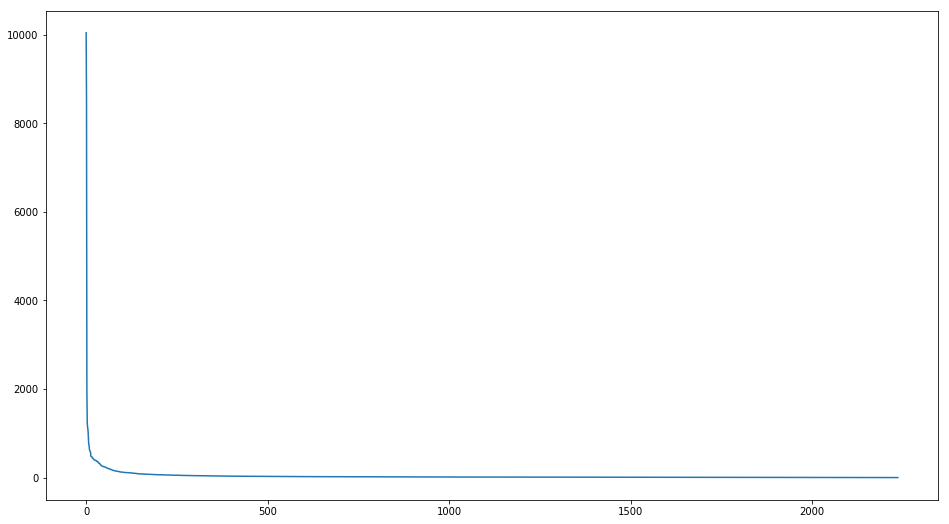

In [27]:
a = bst.get_score(importance_type='gain')
a = pd.Series(a)

a.index = [int(k[1:]) for k in a.index]

b = a.sort_values(ascending=False)

#important_features = b.iloc[:200].index.tolist()

plt.figure(figsize=(16, 9))
plt.plot(a.sort_values(ascending=False).values)

In [28]:
c = b.copy()
c.index = feature_names[c.index]

In [29]:
c.to_csv('eda_11_2_feature_importance_names.csv')
b.to_csv('eda_11_2_feature_importance.csv')

#### Prepare CV

In [38]:
important_features = pd.read_csv('eda_11_2_feature_importance.csv', header=None)

important_features = important_features.iloc[:200, 0].tolist()

In [39]:
x_train, y_train, feature_names, month_in_model, month_test, month_in_cv, df_list = \
    create_train_data(feature_fixed_list, feature_rolling_dict, features=important_features)

31
32
33
34


month_in_model = 31
month_test = 34
month_in_cv = list(range(month_in_model, 35))
cols_cv = {k: list(range(k-month_in_model, k)) for k in month_in_cv} # The last month is test

x_train = {}
y_train = {}
for m in month_in_cv:
    print(m)
    df_list = [test_shop_item, 
           cnt.iloc[:, cols_cv[m]], 
           sales.iloc[:, cols_cv[m]]]
    df_list.extend([feature_dict2[k].iloc[:, cols_cv[m]] 
                    for k in feature_dict2.keys()])
    x_train[m] = pd.concat(df_list, axis=1, sort=False).values[:, important_features]
    if m<month_test:
        # only train months have y_train, test month does not have it
        # clip ground truth since the objective is clipped
        y_train[m] = np.maximum(np.minimum(cnt.iloc[:, m].values, 40.0), 0.0)

In [55]:
param = {'max_depth':14, 
         'subsample':0.7,
         'min_child_weight':3,
         'eta':0.02, 
         'lambda':5,
         'alpha':1,
         'colsample_bytree':0.4,
         'seed':1,
         'silent':1,
         'maximize': False,
         'nthread':8}
n_tree = 200
n_repetition = 5

progress, bst_cv, sub_df = cv_predict_repeat(param, n_tree, n_repetition, 
                                             x_train, y_train, month_in_cv, 
                                             'eda_11.csv', verbose=True)

Repetition 0 starts.
CV of month 31 is started.
[0]	train-rmse:1.19603	val-rmse:1.39304	train-clip-rmse:1.0473	val-clip-rmse:1.13506
[1]	train-rmse:1.18372	val-rmse:1.38435	train-clip-rmse:1.03564	val-clip-rmse:1.1266
[2]	train-rmse:1.17029	val-rmse:1.37548	train-clip-rmse:1.0228	val-clip-rmse:1.11786
[3]	train-rmse:1.15708	val-rmse:1.36635	train-clip-rmse:1.01028	val-clip-rmse:1.10888
[4]	train-rmse:1.14556	val-rmse:1.35864	train-clip-rmse:0.999383	val-clip-rmse:1.10146
[5]	train-rmse:1.13529	val-rmse:1.3517	train-clip-rmse:0.989444	val-clip-rmse:1.09459
[6]	train-rmse:1.12337	val-rmse:1.34653	train-clip-rmse:0.978155	val-clip-rmse:1.08905
[7]	train-rmse:1.11157	val-rmse:1.33864	train-clip-rmse:0.966798	val-clip-rmse:1.08113
[8]	train-rmse:1.10181	val-rmse:1.33241	train-clip-rmse:0.957826	val-clip-rmse:1.0754
[9]	train-rmse:1.09007	val-rmse:1.32561	train-clip-rmse:0.946766	val-clip-rmse:1.06889
[10]	train-rmse:1.08051	val-rmse:1.31958	train-clip-rmse:0.937961	val-clip-rmse:1.06333
[11

[92]	train-rmse:0.649467	val-rmse:1.13515	train-clip-rmse:0.569153	val-clip-rmse:0.920043
[93]	train-rmse:0.647406	val-rmse:1.13487	train-clip-rmse:0.567456	val-clip-rmse:0.919855
[94]	train-rmse:0.64539	val-rmse:1.13426	train-clip-rmse:0.565842	val-clip-rmse:0.919554
[95]	train-rmse:0.642463	val-rmse:1.13383	train-clip-rmse:0.563351	val-clip-rmse:0.919411
[96]	train-rmse:0.640278	val-rmse:1.1334	train-clip-rmse:0.561624	val-clip-rmse:0.919221
[97]	train-rmse:0.637794	val-rmse:1.13311	train-clip-rmse:0.559652	val-clip-rmse:0.919187
[98]	train-rmse:0.636021	val-rmse:1.1327	train-clip-rmse:0.558166	val-clip-rmse:0.918988
[99]	train-rmse:0.634227	val-rmse:1.1324	train-clip-rmse:0.556704	val-clip-rmse:0.918908
[100]	train-rmse:0.632258	val-rmse:1.13195	train-clip-rmse:0.555092	val-clip-rmse:0.918687
[101]	train-rmse:0.629652	val-rmse:1.13168	train-clip-rmse:0.55293	val-clip-rmse:0.918573
[102]	train-rmse:0.628015	val-rmse:1.13126	train-clip-rmse:0.551641	val-clip-rmse:0.918394
[103]	train-

[183]	train-rmse:0.51692	val-rmse:1.1217	train-clip-rmse:0.4603	val-clip-rmse:0.916826
[184]	train-rmse:0.516233	val-rmse:1.12158	train-clip-rmse:0.459679	val-clip-rmse:0.916739
[185]	train-rmse:0.515205	val-rmse:1.12161	train-clip-rmse:0.458857	val-clip-rmse:0.916767
[186]	train-rmse:0.514693	val-rmse:1.1215	train-clip-rmse:0.458435	val-clip-rmse:0.9167
[187]	train-rmse:0.514093	val-rmse:1.12158	train-clip-rmse:0.457944	val-clip-rmse:0.916828
[188]	train-rmse:0.5134	val-rmse:1.12153	train-clip-rmse:0.457344	val-clip-rmse:0.916845
[189]	train-rmse:0.511947	val-rmse:1.12155	train-clip-rmse:0.456148	val-clip-rmse:0.916921
[190]	train-rmse:0.510752	val-rmse:1.12155	train-clip-rmse:0.45519	val-clip-rmse:0.916962
[191]	train-rmse:0.510239	val-rmse:1.12155	train-clip-rmse:0.454742	val-clip-rmse:0.916962
[192]	train-rmse:0.509699	val-rmse:1.12159	train-clip-rmse:0.454292	val-clip-rmse:0.917059
[193]	train-rmse:0.50862	val-rmse:1.12156	train-clip-rmse:0.453471	val-clip-rmse:0.917057
[194]	trai

[75]	train-rmse:0.863483	val-rmse:1.07597	train-clip-rmse:0.669006	val-clip-rmse:0.900872
[76]	train-rmse:0.857501	val-rmse:1.07537	train-clip-rmse:0.664268	val-clip-rmse:0.90054
[77]	train-rmse:0.85517	val-rmse:1.07429	train-clip-rmse:0.662522	val-clip-rmse:0.899954
[78]	train-rmse:0.850098	val-rmse:1.07361	train-clip-rmse:0.658416	val-clip-rmse:0.899741
[79]	train-rmse:0.847744	val-rmse:1.07284	train-clip-rmse:0.656646	val-clip-rmse:0.899564
[80]	train-rmse:0.845528	val-rmse:1.07181	train-clip-rmse:0.654941	val-clip-rmse:0.89892
[81]	train-rmse:0.843314	val-rmse:1.07072	train-clip-rmse:0.65328	val-clip-rmse:0.898449
[82]	train-rmse:0.84124	val-rmse:1.07045	train-clip-rmse:0.651758	val-clip-rmse:0.898804
[83]	train-rmse:0.835634	val-rmse:1.0701	train-clip-rmse:0.647212	val-clip-rmse:0.898905
[84]	train-rmse:0.833494	val-rmse:1.0694	train-clip-rmse:0.645591	val-clip-rmse:0.898766
[85]	train-rmse:0.827695	val-rmse:1.06931	train-clip-rmse:0.640894	val-clip-rmse:0.898747
[86]	train-rmse:0

[166]	train-rmse:0.639037	val-rmse:1.0572	train-clip-rmse:0.506288	val-clip-rmse:0.902649
[167]	train-rmse:0.638353	val-rmse:1.05733	train-clip-rmse:0.505766	val-clip-rmse:0.902794
[168]	train-rmse:0.635372	val-rmse:1.05743	train-clip-rmse:0.504271	val-clip-rmse:0.902964
[169]	train-rmse:0.634695	val-rmse:1.05739	train-clip-rmse:0.503764	val-clip-rmse:0.902985
[170]	train-rmse:0.633925	val-rmse:1.05752	train-clip-rmse:0.50321	val-clip-rmse:0.903184
[171]	train-rmse:0.633321	val-rmse:1.05753	train-clip-rmse:0.502788	val-clip-rmse:0.903273
[172]	train-rmse:0.632617	val-rmse:1.05762	train-clip-rmse:0.502251	val-clip-rmse:0.90342
[173]	train-rmse:0.630088	val-rmse:1.05805	train-clip-rmse:0.500801	val-clip-rmse:0.903854
[174]	train-rmse:0.627172	val-rmse:1.05815	train-clip-rmse:0.499036	val-clip-rmse:0.904056
[175]	train-rmse:0.62665	val-rmse:1.05821	train-clip-rmse:0.498632	val-clip-rmse:0.904223
[176]	train-rmse:0.624098	val-rmse:1.05837	train-clip-rmse:0.49725	val-clip-rmse:0.904403
[177

[102]	train-rmse:0.751256	train-clip-rmse:0.61338
[103]	train-rmse:0.749809	train-clip-rmse:0.612427
[104]	train-rmse:0.748313	train-clip-rmse:0.611424
[105]	train-rmse:0.744526	train-clip-rmse:0.608612
[106]	train-rmse:0.740749	train-clip-rmse:0.605997
[107]	train-rmse:0.739537	train-clip-rmse:0.605187
[108]	train-rmse:0.738216	train-clip-rmse:0.60424
[109]	train-rmse:0.734797	train-clip-rmse:0.601705
[110]	train-rmse:0.73351	train-clip-rmse:0.600756
[111]	train-rmse:0.732267	train-clip-rmse:0.59987
[112]	train-rmse:0.730978	train-clip-rmse:0.598897
[113]	train-rmse:0.72982	train-clip-rmse:0.598124
[114]	train-rmse:0.727031	train-clip-rmse:0.596074
[115]	train-rmse:0.723789	train-clip-rmse:0.59398
[116]	train-rmse:0.720441	train-clip-rmse:0.591494
[117]	train-rmse:0.719323	train-clip-rmse:0.590704
[118]	train-rmse:0.718101	train-clip-rmse:0.589783
[119]	train-rmse:0.716961	train-clip-rmse:0.589042
[120]	train-rmse:0.715738	train-clip-rmse:0.588188
[121]	train-rmse:0.712434	train-clip-

[34]	train-rmse:0.874277	val-rmse:1.21112	train-clip-rmse:0.752803	val-clip-rmse:0.969262
[35]	train-rmse:0.867075	val-rmse:1.20832	train-clip-rmse:0.746555	val-clip-rmse:0.967093
[36]	train-rmse:0.86016	val-rmse:1.20543	train-clip-rmse:0.740552	val-clip-rmse:0.964846
[37]	train-rmse:0.855421	val-rmse:1.2028	train-clip-rmse:0.736773	val-clip-rmse:0.962918
[38]	train-rmse:0.849605	val-rmse:1.19992	train-clip-rmse:0.731985	val-clip-rmse:0.960751
[39]	train-rmse:0.843791	val-rmse:1.19708	train-clip-rmse:0.727182	val-clip-rmse:0.958707
[40]	train-rmse:0.836929	val-rmse:1.19449	train-clip-rmse:0.721428	val-clip-rmse:0.956896
[41]	train-rmse:0.831637	val-rmse:1.1922	train-clip-rmse:0.717102	val-clip-rmse:0.955244
[42]	train-rmse:0.825301	val-rmse:1.19002	train-clip-rmse:0.711849	val-clip-rmse:0.953821
[43]	train-rmse:0.820637	val-rmse:1.18772	train-clip-rmse:0.70807	val-clip-rmse:0.952128
[44]	train-rmse:0.815363	val-rmse:1.18525	train-clip-rmse:0.70382	val-clip-rmse:0.950481
[45]	train-rmse

[126]	train-rmse:0.579077	val-rmse:1.12044	train-clip-rmse:0.512702	val-clip-rmse:0.912523
[127]	train-rmse:0.577935	val-rmse:1.12035	train-clip-rmse:0.511809	val-clip-rmse:0.912537
[128]	train-rmse:0.576729	val-rmse:1.12021	train-clip-rmse:0.510753	val-clip-rmse:0.912497
[129]	train-rmse:0.575605	val-rmse:1.11999	train-clip-rmse:0.509777	val-clip-rmse:0.912382
[130]	train-rmse:0.574383	val-rmse:1.11983	train-clip-rmse:0.508694	val-clip-rmse:0.912285
[131]	train-rmse:0.573175	val-rmse:1.11968	train-clip-rmse:0.507708	val-clip-rmse:0.912248
[132]	train-rmse:0.571406	val-rmse:1.1196	train-clip-rmse:0.506249	val-clip-rmse:0.912233
[133]	train-rmse:0.569479	val-rmse:1.11945	train-clip-rmse:0.504743	val-clip-rmse:0.912143
[134]	train-rmse:0.5683	val-rmse:1.11922	train-clip-rmse:0.503729	val-clip-rmse:0.912012
[135]	train-rmse:0.567162	val-rmse:1.11915	train-clip-rmse:0.502765	val-clip-rmse:0.912016
[136]	train-rmse:0.566079	val-rmse:1.1192	train-clip-rmse:0.501843	val-clip-rmse:0.912126
[13

[17]	train-rmse:1.19726	val-rmse:1.21739	train-clip-rmse:0.949702	val-clip-rmse:1.00239
[18]	train-rmse:1.18478	val-rmse:1.21158	train-clip-rmse:0.938201	val-clip-rmse:0.997305
[19]	train-rmse:1.17769	val-rmse:1.20667	train-clip-rmse:0.931745	val-clip-rmse:0.993168
[20]	train-rmse:1.16631	val-rmse:1.20118	train-clip-rmse:0.92123	val-clip-rmse:0.988572
[21]	train-rmse:1.1594	val-rmse:1.1957	train-clip-rmse:0.914882	val-clip-rmse:0.983916
[22]	train-rmse:1.15284	val-rmse:1.19079	train-clip-rmse:0.908983	val-clip-rmse:0.97987
[23]	train-rmse:1.14181	val-rmse:1.18566	train-clip-rmse:0.898833	val-clip-rmse:0.975611
[24]	train-rmse:1.13502	val-rmse:1.18121	train-clip-rmse:0.892796	val-clip-rmse:0.972066
[25]	train-rmse:1.12402	val-rmse:1.17681	train-clip-rmse:0.882938	val-clip-rmse:0.968589
[26]	train-rmse:1.11358	val-rmse:1.17322	train-clip-rmse:0.873533	val-clip-rmse:0.965623
[27]	train-rmse:1.10381	val-rmse:1.17148	train-clip-rmse:0.86497	val-clip-rmse:0.964994
[28]	train-rmse:1.09806	val

[109]	train-rmse:0.734448	val-rmse:1.06628	train-clip-rmse:0.572473	val-clip-rmse:0.904925
[110]	train-rmse:0.733069	val-rmse:1.06585	train-clip-rmse:0.571396	val-clip-rmse:0.904762
[111]	train-rmse:0.731817	val-rmse:1.06551	train-clip-rmse:0.570419	val-clip-rmse:0.904675
[112]	train-rmse:0.730529	val-rmse:1.06528	train-clip-rmse:0.569434	val-clip-rmse:0.904655
[113]	train-rmse:0.726444	val-rmse:1.06518	train-clip-rmse:0.566649	val-clip-rmse:0.90479
[114]	train-rmse:0.725127	val-rmse:1.06505	train-clip-rmse:0.565667	val-clip-rmse:0.90484
[115]	train-rmse:0.72116	val-rmse:1.06538	train-clip-rmse:0.563079	val-clip-rmse:0.905304
[116]	train-rmse:0.719805	val-rmse:1.06504	train-clip-rmse:0.562106	val-clip-rmse:0.905162
[117]	train-rmse:0.718469	val-rmse:1.06485	train-clip-rmse:0.561094	val-clip-rmse:0.905195
[118]	train-rmse:0.717287	val-rmse:1.06452	train-clip-rmse:0.560167	val-clip-rmse:0.905039
[119]	train-rmse:0.716051	val-rmse:1.06409	train-clip-rmse:0.559257	val-clip-rmse:0.904828
[1

CV of month 32 is finished, uses 85.54 sec, clip-rmse on val 0.9172

Training of month 33 is started.
[0]	train-rmse:1.33147	train-clip-rmse:1.10575
[1]	train-rmse:1.31814	train-clip-rmse:1.09288
[2]	train-rmse:1.3035	train-clip-rmse:1.07891
[3]	train-rmse:1.28931	train-clip-rmse:1.06538
[4]	train-rmse:1.27516	train-clip-rmse:1.05204
[5]	train-rmse:1.26541	train-clip-rmse:1.04288
[6]	train-rmse:1.25517	train-clip-rmse:1.03315
[7]	train-rmse:1.24177	train-clip-rmse:1.02043
[8]	train-rmse:1.23169	train-clip-rmse:1.01088
[9]	train-rmse:1.22227	train-clip-rmse:1.00206
[10]	train-rmse:1.2134	train-clip-rmse:0.993822
[11]	train-rmse:1.20498	train-clip-rmse:0.986104
[12]	train-rmse:1.1958	train-clip-rmse:0.977658
[13]	train-rmse:1.18376	train-clip-rmse:0.966456
[14]	train-rmse:1.17221	train-clip-rmse:0.955817
[15]	train-rmse:1.16388	train-clip-rmse:0.948098
[16]	train-rmse:1.15562	train-clip-rmse:0.940497
[17]	train-rmse:1.14485	train-clip-rmse:0.930576
[18]	train-rmse:1.13398	train-clip-rmse

[163]	train-rmse:0.651225	train-clip-rmse:0.544404
[164]	train-rmse:0.650687	train-clip-rmse:0.544034
[165]	train-rmse:0.648048	train-clip-rmse:0.542109
[166]	train-rmse:0.647516	train-clip-rmse:0.54171
[167]	train-rmse:0.64542	train-clip-rmse:0.540361
[168]	train-rmse:0.643618	train-clip-rmse:0.539198
[169]	train-rmse:0.642991	train-clip-rmse:0.538717
[170]	train-rmse:0.642374	train-clip-rmse:0.538267
[171]	train-rmse:0.640379	train-clip-rmse:0.537065
[172]	train-rmse:0.639792	train-clip-rmse:0.536687
[173]	train-rmse:0.63915	train-clip-rmse:0.536232
[174]	train-rmse:0.638647	train-clip-rmse:0.535907
[175]	train-rmse:0.638053	train-clip-rmse:0.535464
[176]	train-rmse:0.635773	train-clip-rmse:0.534095
[177]	train-rmse:0.633794	train-clip-rmse:0.532832
[178]	train-rmse:0.633149	train-clip-rmse:0.532304
[179]	train-rmse:0.632549	train-clip-rmse:0.531916
[180]	train-rmse:0.631952	train-clip-rmse:0.531529
[181]	train-rmse:0.629868	train-clip-rmse:0.530158
[182]	train-rmse:0.629198	train-cl

[69]	train-rmse:0.710906	val-rmse:1.14727	train-clip-rmse:0.618849	val-clip-rmse:0.925902
[70]	train-rmse:0.707885	val-rmse:1.14647	train-clip-rmse:0.616356	val-clip-rmse:0.925188
[71]	train-rmse:0.703831	val-rmse:1.14527	train-clip-rmse:0.613119	val-clip-rmse:0.924422
[72]	train-rmse:0.701082	val-rmse:1.14456	train-clip-rmse:0.610972	val-clip-rmse:0.923881
[73]	train-rmse:0.698064	val-rmse:1.14375	train-clip-rmse:0.60855	val-clip-rmse:0.923454
[74]	train-rmse:0.69394	val-rmse:1.14287	train-clip-rmse:0.605187	val-clip-rmse:0.922919
[75]	train-rmse:0.690016	val-rmse:1.14216	train-clip-rmse:0.602049	val-clip-rmse:0.922585
[76]	train-rmse:0.687563	val-rmse:1.14135	train-clip-rmse:0.600108	val-clip-rmse:0.92217
[77]	train-rmse:0.684845	val-rmse:1.14062	train-clip-rmse:0.597893	val-clip-rmse:0.921726
[78]	train-rmse:0.681273	val-rmse:1.13984	train-clip-rmse:0.595036	val-clip-rmse:0.921313
[79]	train-rmse:0.677709	val-rmse:1.13908	train-clip-rmse:0.592178	val-clip-rmse:0.920882
[80]	train-rm

[160]	train-rmse:0.534903	val-rmse:1.12054	train-clip-rmse:0.475792	val-clip-rmse:0.913843
[161]	train-rmse:0.534036	val-rmse:1.12044	train-clip-rmse:0.475041	val-clip-rmse:0.913798
[162]	train-rmse:0.532644	val-rmse:1.12029	train-clip-rmse:0.473981	val-clip-rmse:0.913723
[163]	train-rmse:0.531846	val-rmse:1.12018	train-clip-rmse:0.47331	val-clip-rmse:0.913684
[164]	train-rmse:0.530164	val-rmse:1.12014	train-clip-rmse:0.471967	val-clip-rmse:0.913673
[165]	train-rmse:0.528836	val-rmse:1.12017	train-clip-rmse:0.470997	val-clip-rmse:0.913776
[166]	train-rmse:0.527958	val-rmse:1.12011	train-clip-rmse:0.470253	val-clip-rmse:0.913764
[167]	train-rmse:0.526762	val-rmse:1.12014	train-clip-rmse:0.469243	val-clip-rmse:0.913813
[168]	train-rmse:0.525889	val-rmse:1.12005	train-clip-rmse:0.468496	val-clip-rmse:0.913786
[169]	train-rmse:0.524542	val-rmse:1.12014	train-clip-rmse:0.467344	val-clip-rmse:0.913881
[170]	train-rmse:0.523694	val-rmse:1.12009	train-clip-rmse:0.466589	val-clip-rmse:0.913869


[51]	train-rmse:0.958188	val-rmse:1.10675	train-clip-rmse:0.74348	val-clip-rmse:0.918147
[52]	train-rmse:0.954776	val-rmse:1.10496	train-clip-rmse:0.740757	val-clip-rmse:0.917263
[53]	train-rmse:0.951345	val-rmse:1.10322	train-clip-rmse:0.738231	val-clip-rmse:0.915908
[54]	train-rmse:0.94766	val-rmse:1.10114	train-clip-rmse:0.735399	val-clip-rmse:0.914699
[55]	train-rmse:0.939925	val-rmse:1.10057	train-clip-rmse:0.728963	val-clip-rmse:0.914976
[56]	train-rmse:0.936538	val-rmse:1.09843	train-clip-rmse:0.726377	val-clip-rmse:0.913623
[57]	train-rmse:0.929506	val-rmse:1.09685	train-clip-rmse:0.72048	val-clip-rmse:0.912661
[58]	train-rmse:0.926081	val-rmse:1.09493	train-clip-rmse:0.717846	val-clip-rmse:0.911679
[59]	train-rmse:0.919258	val-rmse:1.09527	train-clip-rmse:0.712203	val-clip-rmse:0.912881
[60]	train-rmse:0.91188	val-rmse:1.09401	train-clip-rmse:0.706245	val-clip-rmse:0.912221
[61]	train-rmse:0.90896	val-rmse:1.09273	train-clip-rmse:0.703971	val-clip-rmse:0.911255
[62]	train-rmse

[143]	train-rmse:0.665189	val-rmse:1.0603	train-clip-rmse:0.524091	val-clip-rmse:0.904297
[144]	train-rmse:0.664318	val-rmse:1.06029	train-clip-rmse:0.523442	val-clip-rmse:0.904453
[145]	train-rmse:0.66092	val-rmse:1.06056	train-clip-rmse:0.521421	val-clip-rmse:0.90481
[146]	train-rmse:0.659994	val-rmse:1.06059	train-clip-rmse:0.520751	val-clip-rmse:0.90499
[147]	train-rmse:0.656528	val-rmse:1.06023	train-clip-rmse:0.518693	val-clip-rmse:0.904803
[148]	train-rmse:0.653373	val-rmse:1.06049	train-clip-rmse:0.51681	val-clip-rmse:0.905093
[149]	train-rmse:0.650193	val-rmse:1.06055	train-clip-rmse:0.514914	val-clip-rmse:0.90516
[150]	train-rmse:0.647209	val-rmse:1.06056	train-clip-rmse:0.513114	val-clip-rmse:0.905252
[151]	train-rmse:0.646225	val-rmse:1.0605	train-clip-rmse:0.512455	val-clip-rmse:0.905224
[152]	train-rmse:0.645365	val-rmse:1.06033	train-clip-rmse:0.511906	val-clip-rmse:0.905188
[153]	train-rmse:0.644609	val-rmse:1.06052	train-clip-rmse:0.511376	val-clip-rmse:0.905492
[154]	

[60]	train-rmse:0.872916	train-clip-rmse:0.703376
[61]	train-rmse:0.870095	train-clip-rmse:0.70131
[62]	train-rmse:0.867027	train-clip-rmse:0.699064
[63]	train-rmse:0.860772	train-clip-rmse:0.694136
[64]	train-rmse:0.855045	train-clip-rmse:0.68979
[65]	train-rmse:0.852078	train-clip-rmse:0.687536
[66]	train-rmse:0.847185	train-clip-rmse:0.683639
[67]	train-rmse:0.841658	train-clip-rmse:0.679554
[68]	train-rmse:0.836187	train-clip-rmse:0.675372
[69]	train-rmse:0.83349	train-clip-rmse:0.673446
[70]	train-rmse:0.83078	train-clip-rmse:0.671425
[71]	train-rmse:0.826033	train-clip-rmse:0.667801
[72]	train-rmse:0.823663	train-clip-rmse:0.66612
[73]	train-rmse:0.821025	train-clip-rmse:0.664225
[74]	train-rmse:0.815976	train-clip-rmse:0.660401
[75]	train-rmse:0.810999	train-clip-rmse:0.656702
[76]	train-rmse:0.808826	train-clip-rmse:0.655079
[77]	train-rmse:0.806542	train-clip-rmse:0.653376
[78]	train-rmse:0.802087	train-clip-rmse:0.64994
[79]	train-rmse:0.797381	train-clip-rmse:0.646491
[80]	t

[11]	train-rmse:1.07472	val-rmse:1.30745	train-clip-rmse:0.932867	val-clip-rmse:1.052
[12]	train-rmse:1.06335	val-rmse:1.30097	train-clip-rmse:0.922233	val-clip-rmse:1.04599
[13]	train-rmse:1.05259	val-rmse:1.29534	train-clip-rmse:0.912184	val-clip-rmse:1.04079
[14]	train-rmse:1.04326	val-rmse:1.28913	train-clip-rmse:0.903635	val-clip-rmse:1.03499
[15]	train-rmse:1.03398	val-rmse:1.28293	train-clip-rmse:0.895084	val-clip-rmse:1.02921
[16]	train-rmse:1.02459	val-rmse:1.27702	train-clip-rmse:0.886534	val-clip-rmse:1.02374
[17]	train-rmse:1.01601	val-rmse:1.2715	train-clip-rmse:0.878877	val-clip-rmse:1.01891
[18]	train-rmse:1.0073	val-rmse:1.26617	train-clip-rmse:0.870918	val-clip-rmse:1.01418
[19]	train-rmse:0.999158	val-rmse:1.26147	train-clip-rmse:0.86368	val-clip-rmse:1.01013
[20]	train-rmse:0.989289	val-rmse:1.2564	train-clip-rmse:0.854666	val-clip-rmse:1.00555
[21]	train-rmse:0.981377	val-rmse:1.25214	train-clip-rmse:0.847696	val-clip-rmse:1.00206
[22]	train-rmse:0.974563	val-rmse:1

[103]	train-rmse:0.629496	val-rmse:1.12429	train-clip-rmse:0.553616	val-clip-rmse:0.912945
[104]	train-rmse:0.626602	val-rmse:1.12403	train-clip-rmse:0.551259	val-clip-rmse:0.912876
[105]	train-rmse:0.623946	val-rmse:1.12379	train-clip-rmse:0.549145	val-clip-rmse:0.912865
[106]	train-rmse:0.622272	val-rmse:1.1235	train-clip-rmse:0.547742	val-clip-rmse:0.912745
[107]	train-rmse:0.620601	val-rmse:1.1232	train-clip-rmse:0.546275	val-clip-rmse:0.912604
[108]	train-rmse:0.618963	val-rmse:1.12296	train-clip-rmse:0.544919	val-clip-rmse:0.912526
[109]	train-rmse:0.617483	val-rmse:1.1227	train-clip-rmse:0.543691	val-clip-rmse:0.912454
[110]	train-rmse:0.61482	val-rmse:1.12256	train-clip-rmse:0.541521	val-clip-rmse:0.912454
[111]	train-rmse:0.613405	val-rmse:1.12236	train-clip-rmse:0.540437	val-clip-rmse:0.912433
[112]	train-rmse:0.61197	val-rmse:1.12225	train-clip-rmse:0.539277	val-clip-rmse:0.912464
[113]	train-rmse:0.609787	val-rmse:1.12211	train-clip-rmse:0.537442	val-clip-rmse:0.912439
[114

[194]	train-rmse:0.50927	val-rmse:1.11871	train-clip-rmse:0.454135	val-clip-rmse:0.914318
[195]	train-rmse:0.507889	val-rmse:1.11882	train-clip-rmse:0.453086	val-clip-rmse:0.914452
[196]	train-rmse:0.506873	val-rmse:1.1189	train-clip-rmse:0.452329	val-clip-rmse:0.914586
[197]	train-rmse:0.506317	val-rmse:1.1189	train-clip-rmse:0.45186	val-clip-rmse:0.91462
[198]	train-rmse:0.505573	val-rmse:1.11889	train-clip-rmse:0.451198	val-clip-rmse:0.914654
[199]	train-rmse:0.505055	val-rmse:1.11885	train-clip-rmse:0.450776	val-clip-rmse:0.914665
CV of month 31 is finished, uses 84.97 sec, clip-rmse on val 0.9147

CV of month 32 is started.
[0]	train-rmse:1.39173	val-rmse:1.33437	train-clip-rmse:1.13407	val-clip-rmse:1.10874
[1]	train-rmse:1.3807	val-rmse:1.32615	train-clip-rmse:1.12339	val-clip-rmse:1.10099
[2]	train-rmse:1.37066	val-rmse:1.31811	train-clip-rmse:1.11361	val-clip-rmse:1.09359
[3]	train-rmse:1.35481	val-rmse:1.30871	train-clip-rmse:1.09833	val-clip-rmse:1.08479
[4]	train-rmse:1.344

[86]	train-rmse:0.827363	val-rmse:1.06761	train-clip-rmse:0.640691	val-clip-rmse:0.899285
[87]	train-rmse:0.82544	val-rmse:1.06699	train-clip-rmse:0.639225	val-clip-rmse:0.899116
[88]	train-rmse:0.823753	val-rmse:1.06608	train-clip-rmse:0.637951	val-clip-rmse:0.898649
[89]	train-rmse:0.818069	val-rmse:1.06564	train-clip-rmse:0.633571	val-clip-rmse:0.898581
[90]	train-rmse:0.812913	val-rmse:1.06526	train-clip-rmse:0.629565	val-clip-rmse:0.89852
[91]	train-rmse:0.811311	val-rmse:1.06479	train-clip-rmse:0.628308	val-clip-rmse:0.898397
[92]	train-rmse:0.805877	val-rmse:1.06522	train-clip-rmse:0.624059	val-clip-rmse:0.899341
[93]	train-rmse:0.804478	val-rmse:1.0643	train-clip-rmse:0.623014	val-clip-rmse:0.898742
[94]	train-rmse:0.802597	val-rmse:1.06391	train-clip-rmse:0.621674	val-clip-rmse:0.898961
[95]	train-rmse:0.801099	val-rmse:1.06354	train-clip-rmse:0.620573	val-clip-rmse:0.898954
[96]	train-rmse:0.799362	val-rmse:1.06318	train-clip-rmse:0.619265	val-clip-rmse:0.89904
[97]	train-rms

[177]	train-rmse:0.616982	val-rmse:1.05622	train-clip-rmse:0.49356	val-clip-rmse:0.904742
[178]	train-rmse:0.616382	val-rmse:1.05606	train-clip-rmse:0.493068	val-clip-rmse:0.9047
[179]	train-rmse:0.61377	val-rmse:1.05617	train-clip-rmse:0.491659	val-clip-rmse:0.904874
[180]	train-rmse:0.613117	val-rmse:1.05619	train-clip-rmse:0.491096	val-clip-rmse:0.904913
[181]	train-rmse:0.612503	val-rmse:1.0562	train-clip-rmse:0.490695	val-clip-rmse:0.905043
[182]	train-rmse:0.61191	val-rmse:1.05613	train-clip-rmse:0.490303	val-clip-rmse:0.905032
[183]	train-rmse:0.611275	val-rmse:1.05613	train-clip-rmse:0.489758	val-clip-rmse:0.905098
[184]	train-rmse:0.609202	val-rmse:1.05629	train-clip-rmse:0.48864	val-clip-rmse:0.905314
[185]	train-rmse:0.608543	val-rmse:1.05633	train-clip-rmse:0.488177	val-clip-rmse:0.905469
[186]	train-rmse:0.605784	val-rmse:1.05646	train-clip-rmse:0.486724	val-clip-rmse:0.905619
[187]	train-rmse:0.603081	val-rmse:1.05681	train-clip-rmse:0.485227	val-clip-rmse:0.906029
[188]	

[122]	train-rmse:0.717436	train-clip-rmse:0.589347
[123]	train-rmse:0.714122	train-clip-rmse:0.587158
[124]	train-rmse:0.712953	train-clip-rmse:0.586353
[125]	train-rmse:0.711966	train-clip-rmse:0.585602
[126]	train-rmse:0.708918	train-clip-rmse:0.583299
[127]	train-rmse:0.705773	train-clip-rmse:0.581143
[128]	train-rmse:0.70275	train-clip-rmse:0.579063
[129]	train-rmse:0.701759	train-clip-rmse:0.57831
[130]	train-rmse:0.698487	train-clip-rmse:0.57599
[131]	train-rmse:0.697399	train-clip-rmse:0.575267
[132]	train-rmse:0.694704	train-clip-rmse:0.573451
[133]	train-rmse:0.691923	train-clip-rmse:0.571495
[134]	train-rmse:0.689476	train-clip-rmse:0.569772
[135]	train-rmse:0.687042	train-clip-rmse:0.568239
[136]	train-rmse:0.684123	train-clip-rmse:0.566321
[137]	train-rmse:0.683248	train-clip-rmse:0.565772
[138]	train-rmse:0.6825	train-clip-rmse:0.565263
[139]	train-rmse:0.681533	train-clip-rmse:0.564585
[140]	train-rmse:0.678677	train-clip-rmse:0.562677
[141]	train-rmse:0.6778	train-clip-r

[45]	train-rmse:0.820368	val-rmse:1.18072	train-clip-rmse:0.708249	val-clip-rmse:0.946344
[46]	train-rmse:0.814632	val-rmse:1.17833	train-clip-rmse:0.70339	val-clip-rmse:0.944635
[47]	train-rmse:0.810045	val-rmse:1.17626	train-clip-rmse:0.699875	val-clip-rmse:0.943347
[48]	train-rmse:0.805407	val-rmse:1.17416	train-clip-rmse:0.696123	val-clip-rmse:0.941905
[49]	train-rmse:0.800965	val-rmse:1.17187	train-clip-rmse:0.692718	val-clip-rmse:0.940435
[50]	train-rmse:0.796868	val-rmse:1.17036	train-clip-rmse:0.689476	val-clip-rmse:0.939435
[51]	train-rmse:0.791242	val-rmse:1.16867	train-clip-rmse:0.684861	val-clip-rmse:0.938324
[52]	train-rmse:0.78696	val-rmse:1.167	train-clip-rmse:0.681561	val-clip-rmse:0.93735
[53]	train-rmse:0.781579	val-rmse:1.16572	train-clip-rmse:0.67706	val-clip-rmse:0.936596
[54]	train-rmse:0.776516	val-rmse:1.16447	train-clip-rmse:0.67306	val-clip-rmse:0.936046
[55]	train-rmse:0.771194	val-rmse:1.16284	train-clip-rmse:0.668689	val-clip-rmse:0.93507
[56]	train-rmse:0.

[136]	train-rmse:0.568426	val-rmse:1.12155	train-clip-rmse:0.503313	val-clip-rmse:0.913939
[137]	train-rmse:0.567361	val-rmse:1.12144	train-clip-rmse:0.50243	val-clip-rmse:0.913869
[138]	train-rmse:0.56626	val-rmse:1.12125	train-clip-rmse:0.501514	val-clip-rmse:0.913814
[139]	train-rmse:0.564529	val-rmse:1.12117	train-clip-rmse:0.500039	val-clip-rmse:0.913823
[140]	train-rmse:0.563625	val-rmse:1.12111	train-clip-rmse:0.499291	val-clip-rmse:0.913834
[141]	train-rmse:0.562572	val-rmse:1.121	train-clip-rmse:0.498372	val-clip-rmse:0.913783
[142]	train-rmse:0.561376	val-rmse:1.12086	train-clip-rmse:0.497315	val-clip-rmse:0.913761
[143]	train-rmse:0.559903	val-rmse:1.12083	train-clip-rmse:0.496174	val-clip-rmse:0.913822
[144]	train-rmse:0.558847	val-rmse:1.12076	train-clip-rmse:0.49527	val-clip-rmse:0.913837
[145]	train-rmse:0.557178	val-rmse:1.12077	train-clip-rmse:0.493908	val-clip-rmse:0.913927
[146]	train-rmse:0.556294	val-rmse:1.12063	train-clip-rmse:0.493154	val-clip-rmse:0.913867
[147

[27]	train-rmse:1.11952	val-rmse:1.1721	train-clip-rmse:0.879008	val-clip-rmse:0.965419
[28]	train-rmse:1.11371	val-rmse:1.16845	train-clip-rmse:0.873961	val-clip-rmse:0.962727
[29]	train-rmse:1.10758	val-rmse:1.16455	train-clip-rmse:0.868689	val-clip-rmse:0.959722
[30]	train-rmse:1.0966	val-rmse:1.16184	train-clip-rmse:0.859008	val-clip-rmse:0.958183
[31]	train-rmse:1.09112	val-rmse:1.15868	train-clip-rmse:0.854401	val-clip-rmse:0.955839
[32]	train-rmse:1.08605	val-rmse:1.15539	train-clip-rmse:0.85013	val-clip-rmse:0.953489
[33]	train-rmse:1.08083	val-rmse:1.15191	train-clip-rmse:0.845743	val-clip-rmse:0.950956
[34]	train-rmse:1.07068	val-rmse:1.14894	train-clip-rmse:0.836921	val-clip-rmse:0.94851
[35]	train-rmse:1.06551	val-rmse:1.14517	train-clip-rmse:0.832507	val-clip-rmse:0.94578
[36]	train-rmse:1.0556	val-rmse:1.14212	train-clip-rmse:0.823802	val-clip-rmse:0.943664
[37]	train-rmse:1.05066	val-rmse:1.13899	train-clip-rmse:0.819676	val-clip-rmse:0.941256
[38]	train-rmse:1.04189	val

[119]	train-rmse:0.725543	val-rmse:1.06791	train-clip-rmse:0.564412	val-clip-rmse:0.91057
[120]	train-rmse:0.72156	val-rmse:1.06782	train-clip-rmse:0.561594	val-clip-rmse:0.910592
[121]	train-rmse:0.720379	val-rmse:1.06752	train-clip-rmse:0.560703	val-clip-rmse:0.910518
[122]	train-rmse:0.716559	val-rmse:1.06736	train-clip-rmse:0.557929	val-clip-rmse:0.910625
[123]	train-rmse:0.712409	val-rmse:1.0672	train-clip-rmse:0.55507	val-clip-rmse:0.910649
[124]	train-rmse:0.711304	val-rmse:1.06714	train-clip-rmse:0.554198	val-clip-rmse:0.910697
[125]	train-rmse:0.710185	val-rmse:1.067	train-clip-rmse:0.553396	val-clip-rmse:0.910794
[126]	train-rmse:0.706208	val-rmse:1.06685	train-clip-rmse:0.550681	val-clip-rmse:0.910758
[127]	train-rmse:0.705049	val-rmse:1.0669	train-clip-rmse:0.549818	val-clip-rmse:0.910922
[128]	train-rmse:0.701691	val-rmse:1.06742	train-clip-rmse:0.547759	val-clip-rmse:0.911511
[129]	train-rmse:0.698017	val-rmse:1.06747	train-clip-rmse:0.545278	val-clip-rmse:0.911685
[130]	

[17]	train-rmse:1.14958	train-clip-rmse:0.935749
[18]	train-rmse:1.14167	train-clip-rmse:0.928554
[19]	train-rmse:1.13071	train-clip-rmse:0.918554
[20]	train-rmse:1.12315	train-clip-rmse:0.91178
[21]	train-rmse:1.11574	train-clip-rmse:0.905214
[22]	train-rmse:1.10873	train-clip-rmse:0.898892
[23]	train-rmse:1.09859	train-clip-rmse:0.889819
[24]	train-rmse:1.08902	train-clip-rmse:0.88135
[25]	train-rmse:1.08315	train-clip-rmse:0.876214
[26]	train-rmse:1.07282	train-clip-rmse:0.867138
[27]	train-rmse:1.06625	train-clip-rmse:0.861488
[28]	train-rmse:1.06023	train-clip-rmse:0.856315
[29]	train-rmse:1.05368	train-clip-rmse:0.85086
[30]	train-rmse:1.04405	train-clip-rmse:0.842405
[31]	train-rmse:1.03807	train-clip-rmse:0.837538
[32]	train-rmse:1.03291	train-clip-rmse:0.833331
[33]	train-rmse:1.02738	train-clip-rmse:0.828732
[34]	train-rmse:1.01856	train-clip-rmse:0.82123
[35]	train-rmse:1.01308	train-clip-rmse:0.816807
[36]	train-rmse:1.00469	train-clip-rmse:0.80965
[37]	train-rmse:0.999505	

[181]	train-rmse:0.620283	train-clip-rmse:0.524689
[182]	train-rmse:0.619668	train-clip-rmse:0.524201
[183]	train-rmse:0.619069	train-clip-rmse:0.523786
[184]	train-rmse:0.618598	train-clip-rmse:0.523457
[185]	train-rmse:0.618034	train-clip-rmse:0.523058
[186]	train-rmse:0.616525	train-clip-rmse:0.522021
[187]	train-rmse:0.615981	train-clip-rmse:0.52161
[188]	train-rmse:0.615459	train-clip-rmse:0.521242
[189]	train-rmse:0.614963	train-clip-rmse:0.520835
[190]	train-rmse:0.614453	train-clip-rmse:0.520467
[191]	train-rmse:0.612716	train-clip-rmse:0.51933
[192]	train-rmse:0.610766	train-clip-rmse:0.517988
[193]	train-rmse:0.610321	train-clip-rmse:0.517723
[194]	train-rmse:0.60878	train-clip-rmse:0.516893
[195]	train-rmse:0.606932	train-clip-rmse:0.515826
[196]	train-rmse:0.60653	train-clip-rmse:0.515542
[197]	train-rmse:0.606149	train-clip-rmse:0.515278
[198]	train-rmse:0.604664	train-clip-rmse:0.514444
[199]	train-rmse:0.604169	train-clip-rmse:0.514125
Train of month 33 is finished, uses

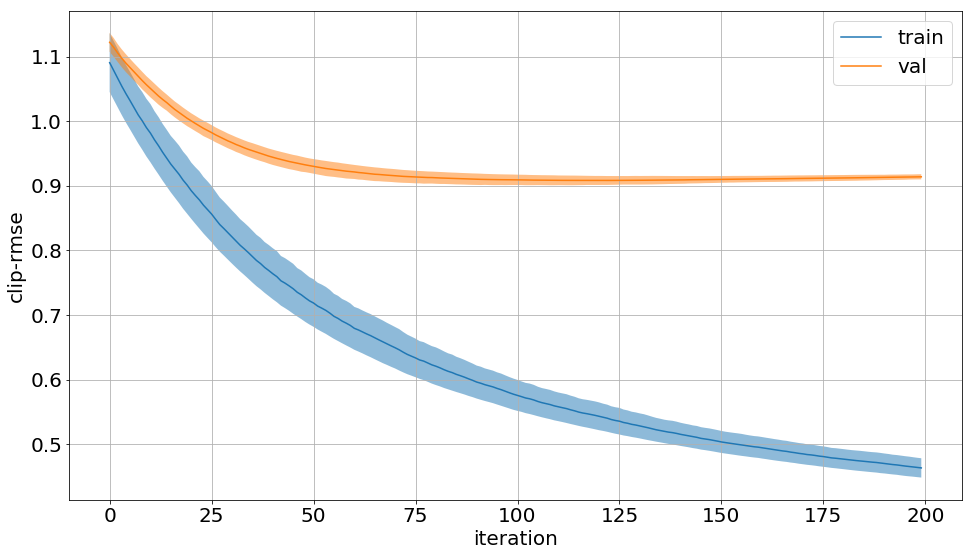

In [56]:
progress_mean = progress.groupby(level=2, axis=1).mean()
progress_std = progress.groupby(level=2, axis=1).std()

val_mean = progress_mean['val'] #progress.xs('val', axis=1, level=1).mean(axis=1)
val_std = progress_std['val'] #progress.xs('val', axis=1, level=1).std(axis=1)

train_mean = progress_mean['train'] #progress.xs('train', axis=1, level=1).mean(axis=1)
train_std = progress_std['train'] #progress.xs('train', axis=1, level=1).std(axis=1)

plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 20})
plt.plot(np.arange(len(train_mean)), train_mean)
plt.fill_between(np.arange(len(train_std)), 
                 train_mean-train_std, 
                 train_mean+train_std, alpha=0.5)
plt.plot(np.arange(len(val_mean)), val_mean)
plt.fill_between(np.arange(len(val_mean)), 
                 val_mean-val_std, 
                 val_mean+val_std, alpha=0.5)
plt.legend(['train', 'val'])
plt.xlabel('iteration')
plt.ylabel('clip-rmse')
plt.grid()

### Train with important 100 features

In [58]:
param = {'max_depth':14, 
         'subsample':0.7,
         'min_child_weight':3,
         'eta':0.02, 
         'lambda':5,
         'alpha':1,
         'colsample_bytree':0.4,
         'seed':1,
         'silent':1,
         'maximize': False,
         'nthread':8}
n_tree = 130
n_model = 10

bst, preds, preds_mean = ensemble(n_model, param, n_tree, x_train, y_train, month_in_cv, 'eda_11.csv', verbose=True)

Start training model 0 on month 33
[0]	train-rmse:1.33199	train-clip-rmse:1.10618
[1]	train-rmse:1.32082	train-clip-rmse:1.09549
[2]	train-rmse:1.30951	train-clip-rmse:1.08463
[3]	train-rmse:1.29848	train-clip-rmse:1.07424
[4]	train-rmse:1.28849	train-clip-rmse:1.06474
[5]	train-rmse:1.27825	train-clip-rmse:1.05503
[6]	train-rmse:1.26845	train-clip-rmse:1.04578
[7]	train-rmse:1.25562	train-clip-rmse:1.03366
[8]	train-rmse:1.24256	train-clip-rmse:1.02128
[9]	train-rmse:1.23317	train-clip-rmse:1.01245
[10]	train-rmse:1.22376	train-clip-rmse:1.00365
[11]	train-rmse:1.21486	train-clip-rmse:0.995353
[12]	train-rmse:1.2021	train-clip-rmse:0.983488
[13]	train-rmse:1.19372	train-clip-rmse:0.975758
[14]	train-rmse:1.18526	train-clip-rmse:0.967899
[15]	train-rmse:1.17693	train-clip-rmse:0.960319
[16]	train-rmse:1.1653	train-clip-rmse:0.949608
[17]	train-rmse:1.15774	train-clip-rmse:0.942822
[18]	train-rmse:1.15061	train-clip-rmse:0.936405
[19]	train-rmse:1.13976	train-clip-rmse:0.926612
[20]	tra

[32]	train-rmse:1.00857	train-clip-rmse:0.811953
[33]	train-rmse:1.00068	train-clip-rmse:0.805191
[34]	train-rmse:0.993664	train-clip-rmse:0.799484
[35]	train-rmse:0.986492	train-clip-rmse:0.793577
[36]	train-rmse:0.980993	train-clip-rmse:0.789099
[37]	train-rmse:0.975367	train-clip-rmse:0.78451
[38]	train-rmse:0.970123	train-clip-rmse:0.780279
[39]	train-rmse:0.964945	train-clip-rmse:0.776086
[40]	train-rmse:0.960301	train-clip-rmse:0.772487
[41]	train-rmse:0.955322	train-clip-rmse:0.768496
[42]	train-rmse:0.948087	train-clip-rmse:0.762747
[43]	train-rmse:0.940947	train-clip-rmse:0.75704
[44]	train-rmse:0.936228	train-clip-rmse:0.753343
[45]	train-rmse:0.932422	train-clip-rmse:0.750567
[46]	train-rmse:0.927834	train-clip-rmse:0.746929
[47]	train-rmse:0.92356	train-clip-rmse:0.743589
[48]	train-rmse:0.919382	train-clip-rmse:0.740373
[49]	train-rmse:0.915224	train-clip-rmse:0.737172
[50]	train-rmse:0.908585	train-clip-rmse:0.732025
[51]	train-rmse:0.90205	train-clip-rmse:0.726885
[52]	t

[63]	train-rmse:0.865879	train-clip-rmse:0.698197
[64]	train-rmse:0.860071	train-clip-rmse:0.693709
[65]	train-rmse:0.857215	train-clip-rmse:0.691546
[66]	train-rmse:0.851797	train-clip-rmse:0.687324
[67]	train-rmse:0.848912	train-clip-rmse:0.68519
[68]	train-rmse:0.843242	train-clip-rmse:0.680868
[69]	train-rmse:0.840699	train-clip-rmse:0.678929
[70]	train-rmse:0.838171	train-clip-rmse:0.677093
[71]	train-rmse:0.833268	train-clip-rmse:0.673381
[72]	train-rmse:0.829328	train-clip-rmse:0.670232
[73]	train-rmse:0.824621	train-clip-rmse:0.66663
[74]	train-rmse:0.819776	train-clip-rmse:0.662871
[75]	train-rmse:0.817253	train-clip-rmse:0.660993
[76]	train-rmse:0.814777	train-clip-rmse:0.65913
[77]	train-rmse:0.812475	train-clip-rmse:0.657421
[78]	train-rmse:0.810267	train-clip-rmse:0.655813
[79]	train-rmse:0.808199	train-clip-rmse:0.654386
[80]	train-rmse:0.803598	train-clip-rmse:0.650825
[81]	train-rmse:0.801429	train-clip-rmse:0.649279
[82]	train-rmse:0.799295	train-clip-rmse:0.647704
[83

[94]	train-rmse:0.751634	train-clip-rmse:0.614152
[95]	train-rmse:0.749903	train-clip-rmse:0.61299
[96]	train-rmse:0.746596	train-clip-rmse:0.610484
[97]	train-rmse:0.742714	train-clip-rmse:0.607827
[98]	train-rmse:0.741224	train-clip-rmse:0.606693
[99]	train-rmse:0.739756	train-clip-rmse:0.605669
[100]	train-rmse:0.73657	train-clip-rmse:0.603402
[101]	train-rmse:0.734948	train-clip-rmse:0.602331
[102]	train-rmse:0.731602	train-clip-rmse:0.59992
[103]	train-rmse:0.730119	train-clip-rmse:0.598826
[104]	train-rmse:0.728621	train-clip-rmse:0.597802
[105]	train-rmse:0.727209	train-clip-rmse:0.596803
[106]	train-rmse:0.72587	train-clip-rmse:0.595898
[107]	train-rmse:0.724424	train-clip-rmse:0.594879
[108]	train-rmse:0.723048	train-clip-rmse:0.593932
[109]	train-rmse:0.721561	train-clip-rmse:0.592914
[110]	train-rmse:0.71853	train-clip-rmse:0.590775
[111]	train-rmse:0.717254	train-clip-rmse:0.589869
[112]	train-rmse:0.71591	train-clip-rmse:0.588917
[113]	train-rmse:0.714561	train-clip-rmse:0

[125]	train-rmse:0.691142	train-clip-rmse:0.572222
[126]	train-rmse:0.690113	train-clip-rmse:0.571453
[127]	train-rmse:0.689171	train-clip-rmse:0.570844
[128]	train-rmse:0.68656	train-clip-rmse:0.56924
[129]	train-rmse:0.683672	train-clip-rmse:0.567278
Train of model 4 on month 33 is finished, uses 52.49 sec.

Start predicting model 4 on month 34.
Prediction of model 4 on month 34 is finished.

---------------------------------------

Start training model 5 on month 33
[0]	train-rmse:1.33111	train-clip-rmse:1.10553
[1]	train-rmse:1.31947	train-clip-rmse:1.09435
[2]	train-rmse:1.30616	train-clip-rmse:1.0817
[3]	train-rmse:1.29506	train-clip-rmse:1.07115
[4]	train-rmse:1.28455	train-clip-rmse:1.06111
[5]	train-rmse:1.27086	train-clip-rmse:1.04832
[6]	train-rmse:1.25677	train-clip-rmse:1.03505
[7]	train-rmse:1.24345	train-clip-rmse:1.02245
[8]	train-rmse:1.23015	train-clip-rmse:1.01008
[9]	train-rmse:1.21758	train-clip-rmse:0.998296
[10]	train-rmse:1.20866	train-clip-rmse:0.989747
[11]	tr

[22]	train-rmse:1.1053	train-clip-rmse:0.896081
[23]	train-rmse:1.09524	train-clip-rmse:0.887043
[24]	train-rmse:1.08866	train-clip-rmse:0.881337
[25]	train-rmse:1.0819	train-clip-rmse:0.875414
[26]	train-rmse:1.07526	train-clip-rmse:0.869692
[27]	train-rmse:1.06567	train-clip-rmse:0.86121
[28]	train-rmse:1.0558	train-clip-rmse:0.852661
[29]	train-rmse:1.04944	train-clip-rmse:0.847234
[30]	train-rmse:1.04347	train-clip-rmse:0.842285
[31]	train-rmse:1.03768	train-clip-rmse:0.837407
[32]	train-rmse:1.03204	train-clip-rmse:0.832719
[33]	train-rmse:1.02614	train-clip-rmse:0.82796
[34]	train-rmse:1.02059	train-clip-rmse:0.823422
[35]	train-rmse:1.0161	train-clip-rmse:0.819646
[36]	train-rmse:1.01058	train-clip-rmse:0.815132
[37]	train-rmse:1.00199	train-clip-rmse:0.807911
[38]	train-rmse:0.996705	train-clip-rmse:0.803715
[39]	train-rmse:0.988129	train-clip-rmse:0.796457
[40]	train-rmse:0.983369	train-clip-rmse:0.792634
[41]	train-rmse:0.979019	train-clip-rmse:0.789071
[42]	train-rmse:0.9741

[53]	train-rmse:0.902132	train-clip-rmse:0.726667
[54]	train-rmse:0.898337	train-clip-rmse:0.723677
[55]	train-rmse:0.894659	train-clip-rmse:0.720917
[56]	train-rmse:0.891943	train-clip-rmse:0.718928
[57]	train-rmse:0.886308	train-clip-rmse:0.714422
[58]	train-rmse:0.883224	train-clip-rmse:0.7121
[59]	train-rmse:0.877389	train-clip-rmse:0.707645
[60]	train-rmse:0.871315	train-clip-rmse:0.702923
[61]	train-rmse:0.868047	train-clip-rmse:0.700465
[62]	train-rmse:0.862063	train-clip-rmse:0.695795
[63]	train-rmse:0.858957	train-clip-rmse:0.693458
[64]	train-rmse:0.856139	train-clip-rmse:0.691405
[65]	train-rmse:0.853254	train-clip-rmse:0.689234
[66]	train-rmse:0.847684	train-clip-rmse:0.684904
[67]	train-rmse:0.844654	train-clip-rmse:0.682717
[68]	train-rmse:0.839436	train-clip-rmse:0.678694
[69]	train-rmse:0.833892	train-clip-rmse:0.674507
[70]	train-rmse:0.831147	train-clip-rmse:0.672517
[71]	train-rmse:0.828506	train-clip-rmse:0.670558
[72]	train-rmse:0.825847	train-clip-rmse:0.668598
[7

[84]	train-rmse:0.798137	train-clip-rmse:0.647988
[85]	train-rmse:0.796189	train-clip-rmse:0.646638
[86]	train-rmse:0.79135	train-clip-rmse:0.643029
[87]	train-rmse:0.789388	train-clip-rmse:0.641556
[88]	train-rmse:0.785464	train-clip-rmse:0.638554
[89]	train-rmse:0.783658	train-clip-rmse:0.637155
[90]	train-rmse:0.781898	train-clip-rmse:0.635975
[91]	train-rmse:0.780197	train-clip-rmse:0.63476
[92]	train-rmse:0.776537	train-clip-rmse:0.631952
[93]	train-rmse:0.774803	train-clip-rmse:0.630598
[94]	train-rmse:0.770611	train-clip-rmse:0.627487
[95]	train-rmse:0.76891	train-clip-rmse:0.626245
[96]	train-rmse:0.767271	train-clip-rmse:0.625097
[97]	train-rmse:0.765773	train-clip-rmse:0.624071
[98]	train-rmse:0.764342	train-clip-rmse:0.623015
[99]	train-rmse:0.763016	train-clip-rmse:0.622042
[100]	train-rmse:0.76145	train-clip-rmse:0.620888
[101]	train-rmse:0.75997	train-clip-rmse:0.619852
[102]	train-rmse:0.758677	train-clip-rmse:0.619006
[103]	train-rmse:0.757352	train-clip-rmse:0.618029
[

[115]	train-rmse:0.728119	train-clip-rmse:0.597427
[116]	train-rmse:0.727003	train-clip-rmse:0.596637
[117]	train-rmse:0.723668	train-clip-rmse:0.594391
[118]	train-rmse:0.722602	train-clip-rmse:0.593641
[119]	train-rmse:0.721431	train-clip-rmse:0.592799
[120]	train-rmse:0.720355	train-clip-rmse:0.592092
[121]	train-rmse:0.719346	train-clip-rmse:0.591371
[122]	train-rmse:0.718232	train-clip-rmse:0.590645
[123]	train-rmse:0.717115	train-clip-rmse:0.589798
[124]	train-rmse:0.713756	train-clip-rmse:0.587536
[125]	train-rmse:0.712835	train-clip-rmse:0.586895
[126]	train-rmse:0.711844	train-clip-rmse:0.586096
[127]	train-rmse:0.708686	train-clip-rmse:0.583916
[128]	train-rmse:0.707698	train-clip-rmse:0.583211
[129]	train-rmse:0.704792	train-clip-rmse:0.581161
Train of model 9 on month 33 is finished, uses 51.32 sec.

Start predicting model 9 on month 34.
Prediction of model 9 on month 34 is finished.

---------------------------------------

